In [6]:
#Installing the necessary libraries

!pip install opencv-python matplotlib tensorflow

In [7]:
#importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import imghdr

In [8]:
#Providing the dataset directory

data_dir = '/content/drive/MyDrive/Brain Tumor MRI Images/Data'

In [9]:
#Removing images that don't have the correct extension
import os
import cv2
import imghdr

extensions = ['jpg', 'jpeg', 'png', 'bmp']


for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)

    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)

        try:
            img = cv2.imread(image_path)
            file_type = imghdr.what(image_path)

            if file_type not in extensions:
                print("Invalid file type. Removing:", image_path)
                os.remove(image_path)
            elif img is None:
                # Image cannot be loaded (corrupted file)
                print("Corrupted image. Removing:", image_path)
                os.remove(image_path)

        except Exception as e:
            print(f"Error processing file {image_path}: {e}")


In [10]:
#Loading the dataset

dataset = tf.keras.utils.image_dataset_from_directory(data_dir, color_mode = 'grayscale', image_size= (256,256), batch_size = 32)


Found 4999 files belonging to 2 classes.


In [11]:
#Viewing the numpy data in one batch

batch = dataset.as_numpy_iterator().next()
batch[0].shape

(32, 256, 256, 1)

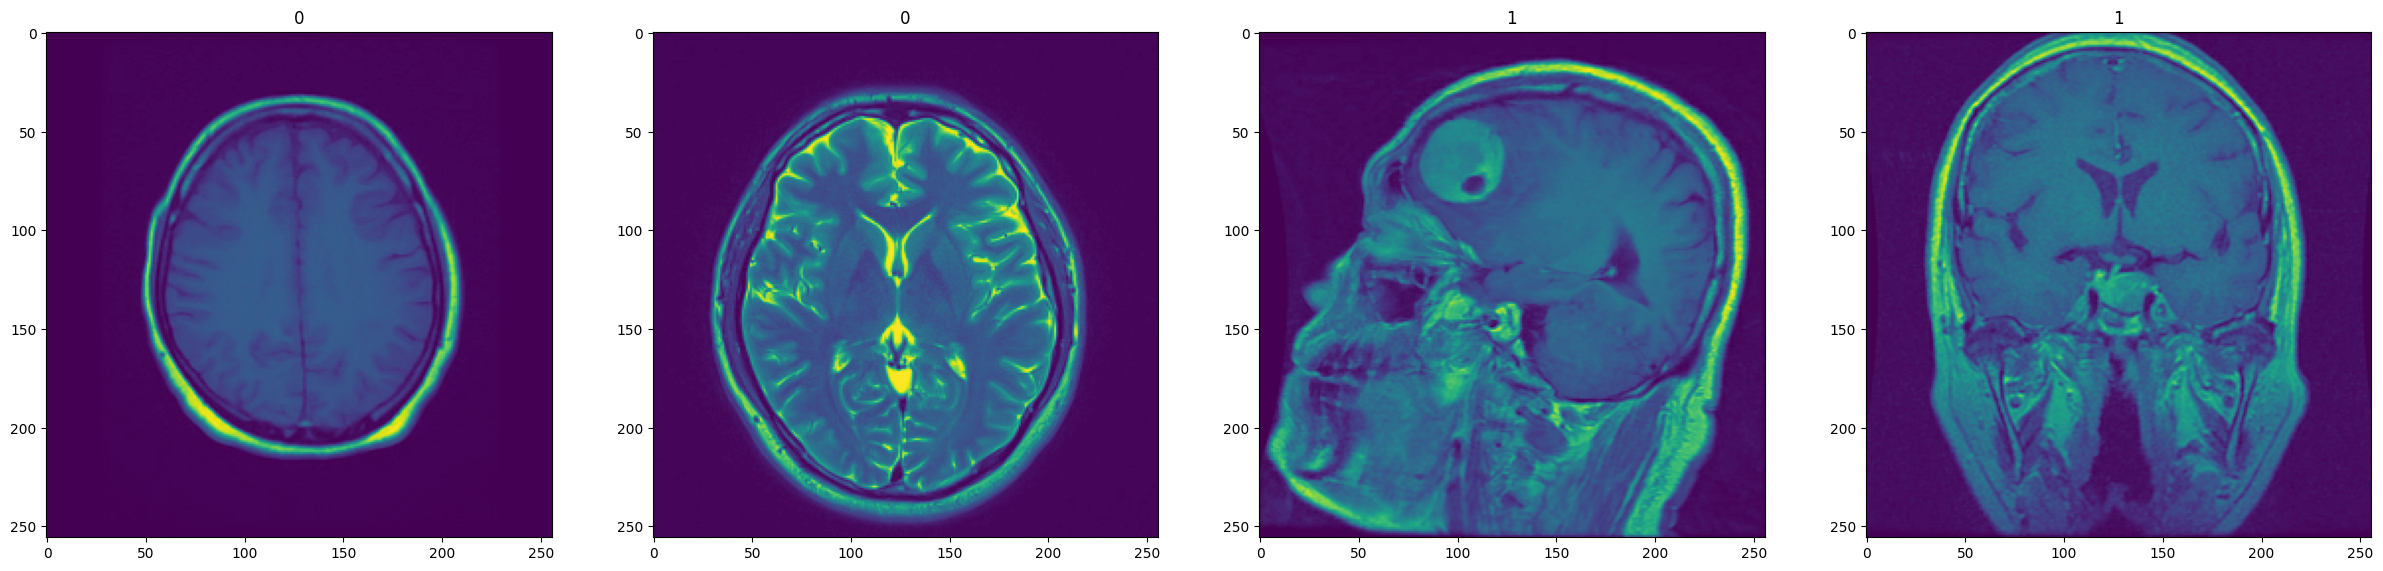

In [12]:
#Visualizing the images

fig, ax = plt.subplots(ncols = 4, figsize = (30,30))

for index, image in enumerate(batch[0][:4]):
  ax[index].imshow(image.astype(int))
  ax[index].title.set_text(batch[1][index])
plt.show()

As we can see, class 0 represents a healthy brain, while class 1 represents a tumorous brain

### Preprocessing

In [13]:
#Scaling

dataset = dataset.map(lambda X, y: (X/255, y))


In [14]:
#Minimum scaled value

dataset.as_numpy_iterator().next()[0].min()

0.0

In [15]:
#Maximum scaled value

dataset.as_numpy_iterator().next()[0].max()

1.0

#### Splitting

In [16]:
data_length = len(dataset)
data_length

157

In [17]:
train_size = int(len(dataset)*0.7)
val_size = int(len(dataset) * 0.2)
test_size = data_length - train_size - val_size

print(train_size)
print(val_size)
print(test_size)


109
31
17


In [18]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size + val_size).take(test_size)

print('Train-', len(train))
print('Val-', len(val))
print('Test-', len(test))

Train- 109
Val- 31
Test- 17


### Building the CNN Model

In [19]:
#importing the necessary libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D

In [20]:
#Initializing the model

model = Sequential()

# Creating the model
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (6, 6), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
#Compiling the model

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
#Getting the summary of the model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 58, 58, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 58, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 951,105 (3.63 MB)

 Trainable params: 950,273 (3.63 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
#Fitting the model

history = model.fit(train, validation_data = val, epochs= 5)

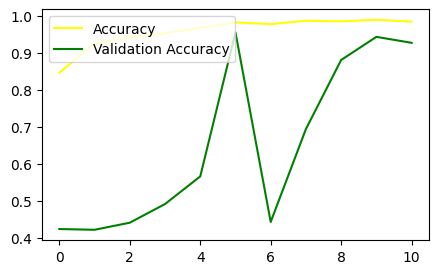

In [65]:
#plotting the accuracy

plt.figure(figsize = (5,3))
plt.plot(history.history['accuracy'], color = 'yellow', label = 'Accuracy')
plt.plot(history.history['val_accuracy'], color = 'green', label = 'Validation Accuracy')
plt.legend(loc = 'upper left')
plt.show()

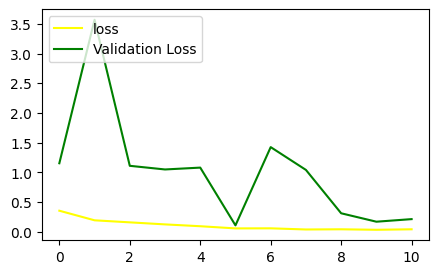

In [66]:
#plotting the Loss

plt.figure(figsize = (5,3))
plt.plot(history.history['loss'], color = 'yellow', label = 'loss')
plt.plot(history.history['val_loss'], color = 'green', label = 'Validation Loss')
plt.legend(loc = 'upper left')
plt.show()

In [30]:
#Evaluation of the model

from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy

In [33]:
re = Recall()
pre = Precision()
acc = BinaryAccuracy()

for batch in dataset.as_numpy_iterator():
  X,y = batch
  ypred = model.predict(X)
  re.update_state(y,ypred)
  pre.update_state(y,ypred)
  acc.update_state(y,ypred)

print('recall:', re.result().numpy())
print('precision:', pre.result().numpy())
print('binary accuracy:', acc.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

### Testing on new images

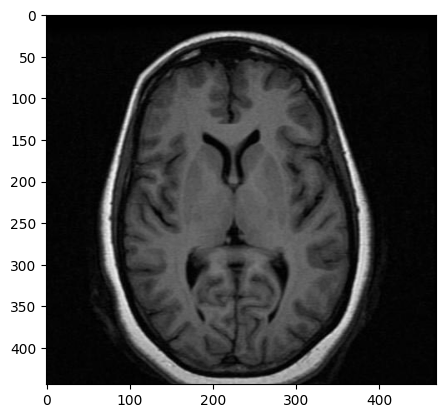

In [38]:
#Healthy

healthy_dir = '/content/drive/MyDrive/Brain Tumor MRI Images/Data/healthy_test.jpg'

##loading the image

img = cv2.imread(healthy_dir, cv2.IMREAD_GRAYSCALE)
img = img[..., tf.newaxis]
plt.imshow(img, cmap = 'gray')
plt.show()

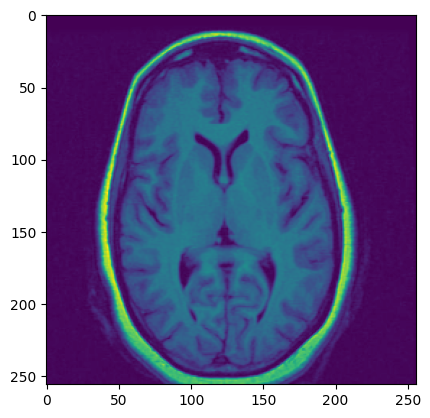

In [39]:
#resizing the photo

resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [40]:
#making predictions

pred = model.predict(np.expand_dims(resize/255, 0))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


array([[0.00057043]], dtype=float32)

The prediction is close to 0 thus it is a healthy brain image

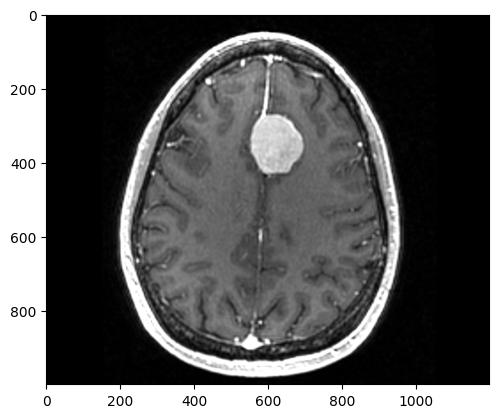

In [59]:
#Tumorous

path = '/content/drive/MyDrive/Brain Tumor MRI Images/Data/tumor_test.jpg'

image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
image = image[..., tf.newaxis]
plt.imshow(image, cmap = 'gray')
plt.show()

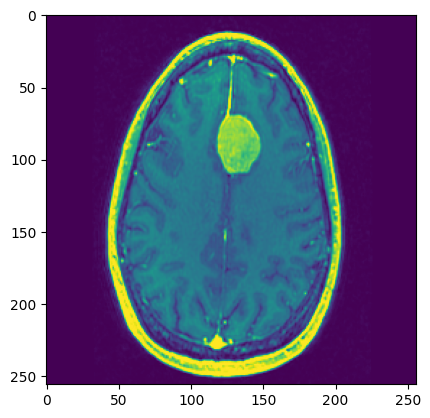

In [61]:
#Resizing

resize2 = tf.image.resize(image, (256,256))
plt.imshow(resize2.numpy().astype(int))
plt.show()

In [67]:
#Prediction

prediction = model.predict(np.expand_dims(resize2/255,0))
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


array([[0.72630024]], dtype=float32)

The prediction is closer to 1 than 0 thus, this is a tumorous brain image

In [64]:
#Saving the model

model_dir = '/content/drive/MyDrive/Brain Tumor MRI Images/Model'

model.save(os.path.join(model_dir,'MRI_Brain_Classification.h5'))